In [12]:
from copy import deepcopy
import pandas as pd
import numpy as np
import scipy.linalg
from scipy.ndimage import gaussian_filter1d
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 20})

In [2]:
data = pd.read_csv('datafiles/rgofull_nan.csv').drop(columns=['type', 'obs_umbral_area', 'corr_umbral_area'])
data['obs_time'] = pd.to_datetime(data['obs_time'])

In [3]:
grouped_data = data.groupby('id')
bad_indices = grouped_data.size()[grouped_data.size() > 16].index
data = data.drop(data.index[np.isin(data.id, bad_indices)])

In [4]:
data.head()

,obs_time,id,obs_whole_area,corr_whole_area,center_dist,pos_angle,carrington_lon,lat,center_meridian_dist
0,1874-05-09 11:55:40,8600,639.0,378.0,0.535,71.1,171.6,7.4,-30.7
1,1874-05-09 11:55:40,8700,1159.0,852.0,0.733,96.8,155.1,-7.0,-47.2
2,1874-05-09 11:55:40,8800,84.0,68.0,0.783,299.3,249.1,20.5,46.8
3,1874-05-10 00:00:00,8500,169.0,167.0,0.862,265.7,248.5,-5.2,59.7
4,1874-05-10 00:00:00,8600,541.0,287.0,0.334,58.5,172.2,7.3,-16.7


## Filtration

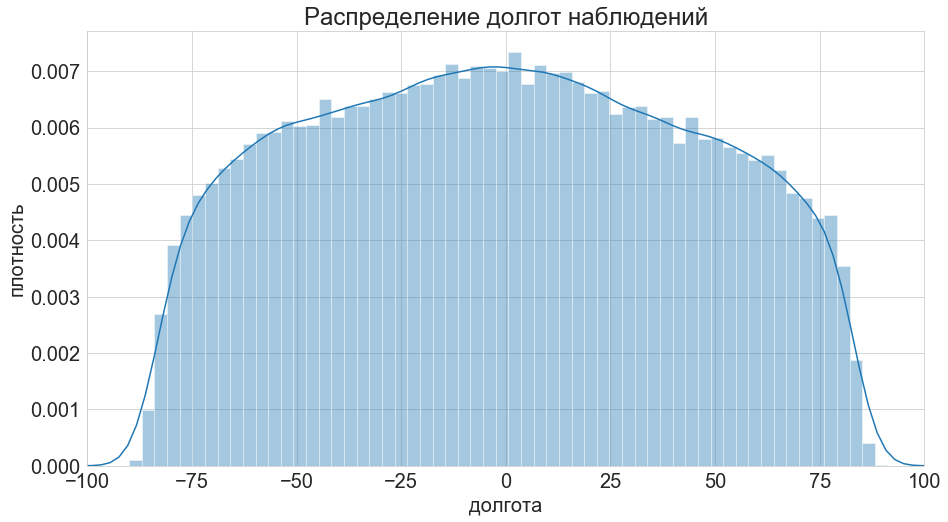

In [24]:
plt.figure(figsize=(15, 8))
sns.distplot(data.center_meridian_dist.dropna(), bins=80)
plt.xlim(-100, 100)
plt.xlabel('долгота')
plt.ylabel('плотность')
plt.title('Распределение долгот наблюдений')
plt.savefig('images/longitude')
plt.show()

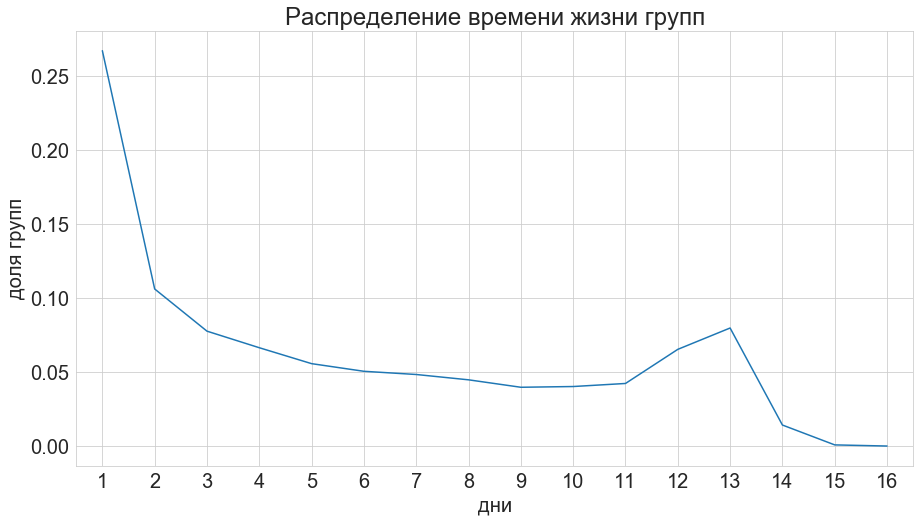

In [21]:
plt.figure(figsize=(15, 8))
grouped_data = data.groupby('id')
unique, counts = np.unique(grouped_data.size(), return_counts=True)
sns.lineplot(unique, counts / counts.sum())
#sns.distplot(grouped_data.size(), kde=False, norm_hist=True, bins=np.arange(0.5, 15, 1))
plt.xlabel('дни')
plt.ylabel('доля групп')
plt.xticks(np.arange(1, 17))
plt.xlim(0.5, 16.5)
plt.title('Распределение времени жизни групп')
plt.savefig('images/init_lifetime')
plt.show()

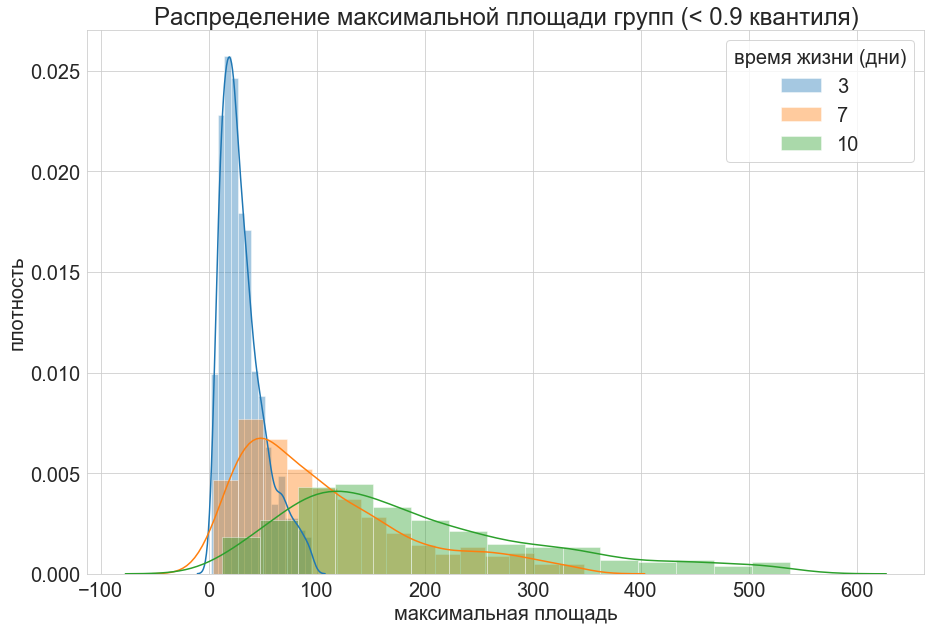

In [26]:
fig = plt.figure(figsize=(15, 10))
grouped_data = data.groupby('id')

for days in [3, 7, 10]:
    areas = grouped_data.max().corr_whole_area[grouped_data.size() == days]
    qt = np.quantile(areas, 0.9)
    sns.distplot(areas[areas < qt], bins=15, label=str(days))

plt.xlabel('максимальная площадь')
plt.ylabel('плотность')
plt.legend(title='время жизни (дни)')
plt.title('Распределение максимальной площади групп (< 0.9 квантиля)')
plt.savefig('images/max_area')
plt.show()

In [5]:
from transformers import SequenceGenerator, VectorTransformer

In [11]:
seq_gen = SequenceGenerator(filter_area=0, filter_longitude=100, verbose=True)
histories = seq_gen.transform(data)

In [12]:
vec_trans = VectorTransformer(length=1)
X, y = vec_trans.transform(histories)

In [13]:
seq_gen = SequenceGenerator(verbose=True, filter_area=35.0, filter_longitude=60.0)
histories_filtered = seq_gen.transform(data)

In [14]:
vec_trans = VectorTransformer(length=1)
X_filtered, y_filtered = vec_trans.transform(histories_filtered)

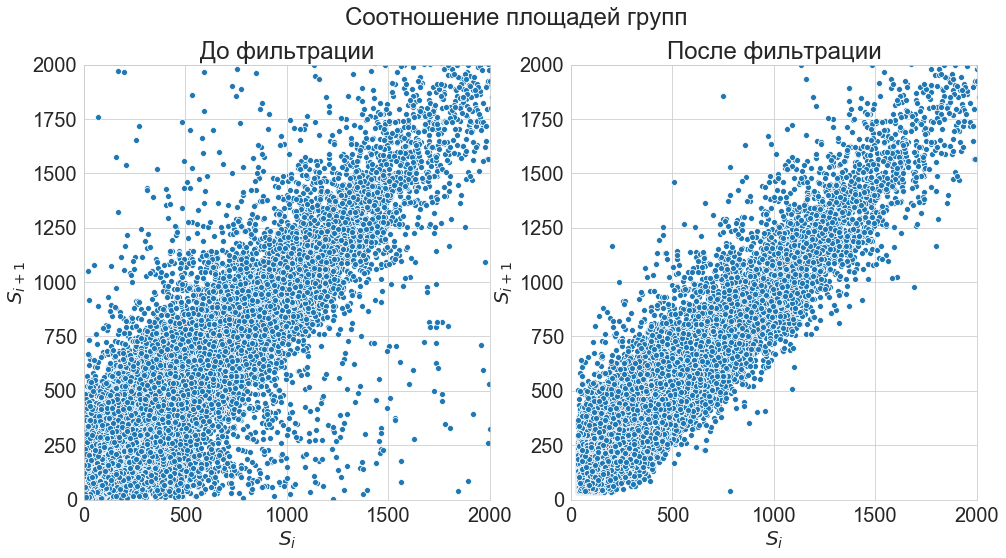

In [15]:
_, axs = plt.subplots(1, 2, figsize=(16, 8))

sns.scatterplot(X[:, -1], y, ax=axs[0])
sns.scatterplot(X_filtered[:, -1], y_filtered, ax=axs[1])

for ax in axs:
    ax.set_xlim(0, 2000)
    ax.set_ylim(0, 2000)
    ax.set_xlabel(r'$S_{i}$')
    ax.set_ylabel(r'$S_{i+1}$')

axs[0].set_title('До фильтрации')
axs[1].set_title('После фильтрации')
plt.suptitle('Соотношение площадей групп')
plt.savefig('images/relation')
plt.show()

## Model Selection

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

from transformers import SequenceGenerator, VectorTransformer
from metrics import nan_rmse, nan_rmsle, rmsle, evaluate_model
from models import LinearModel, MultiDimensionalRegressor

In [8]:
seq_gen = SequenceGenerator(verbose=True)
histories_filtered = seq_gen.transform(data)
train_histories, test_histories = train_test_split(histories_filtered, random_state=42)

In [9]:
vec_trans = VectorTransformer(length=3)
X_train, y_train = vec_trans.transform(train_histories)
X_test, y_test = vec_trans.transform(test_histories)

In [10]:
one_day_results = np.zeros((5, 26))
seq_results = np.zeros((5, 26))
for n in tqdm(range(1, 6)):
    vec_trans = VectorTransformer(length=n)
    X_train, y_train = vec_trans.transform(train_histories)
    X_test, y_test = vec_trans.transform(test_histories)
    for (i, k) in enumerate(range(1, 52, 2)):
        knn_regr = KNeighborsRegressor(n_neighbors=k)
        knn_regr.fit(X_train, y_train)
        one_day_results[n - 1, i] = np.sqrt(mean_squared_error(y_test, knn_regr.predict(X_test)))
        seq_results[n - 1, i] = evaluate_model(knn_regr, test_histories, n, nan_rmse, threshold=-np.inf)

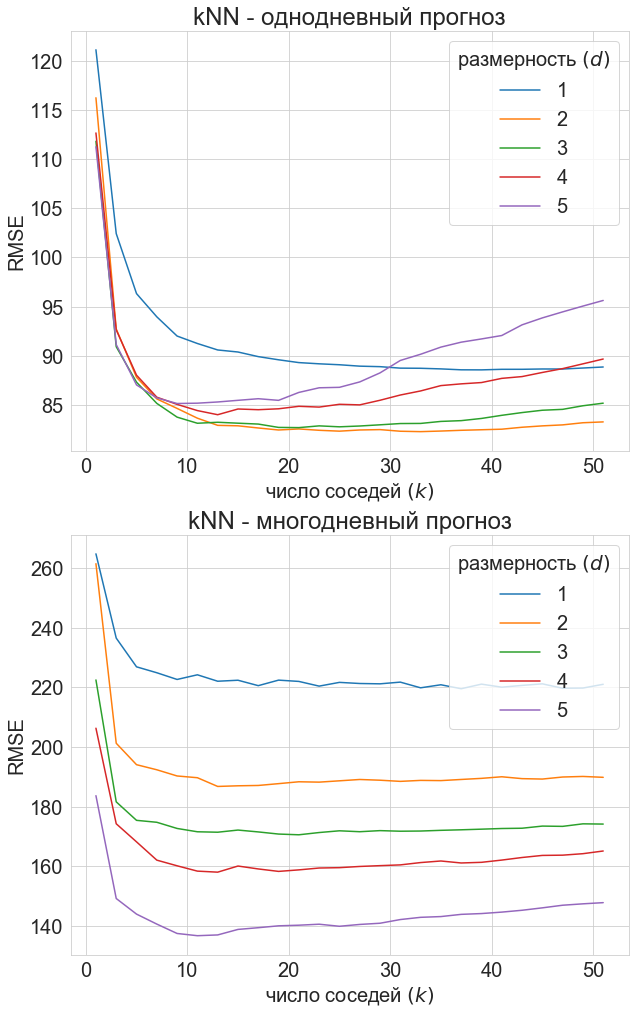

In [13]:
fig, axs = plt.subplots(figsize=(10, 17), nrows=2, ncols=1)

for i in range(5):
    sns.lineplot(range(1, 52, 2), one_day_results[i], label=str(i + 1), ax=axs[0])
    sns.lineplot(range(1, 52, 2), seq_results[i], label=str(i + 1), ax=axs[1])

for ax in axs:
    ax.legend(title=r'размерность $(d)$', loc='upper right')
    ax.set_xlabel(r'число соседей $(k)$')
    ax.set_ylabel('RMSE')

axs[0].set_title('kNN - однодневный прогноз')
axs[1].set_title('kNN - многодневный прогноз')
plt.savefig('images/models/knn_rmse')
plt.show()

In [14]:
one_day_results = np.zeros((5, 3))
seq_results = np.zeros((5, 3))
for n in range(1, 6):
    vec_trans = VectorTransformer(length=n)
    X_train, y_train = vec_trans.transform(train_histories)
    X_test, y_test = vec_trans.transform(test_histories)
    
    knn_regr = KNeighborsRegressor(n_neighbors=12)
    knn_regr.fit(X_train, y_train)
    one_day_results[n - 1, 0] = np.sqrt(mean_squared_error(y_test, knn_regr.predict(X_test)))
    seq_results[n - 1, 0] = evaluate_model(knn_regr, test_histories, n, nan_rmse, threshold=-np.inf)
        
    lin_regr = LinearRegression()
    lin_regr.fit(X_train, y_train)
    one_day_results[n - 1, 1] = np.sqrt(mean_squared_error(y_test, lin_regr.predict(X_test)))
    seq_results[n - 1, 1] = evaluate_model(lin_regr, test_histories, n, nan_rmse, threshold=-np.inf)
    
    log_regr = LinearModel(x_transform=np.log1p, y_transform=np.log1p, y_inverse_transform=np.expm1)
    log_regr.fit(X_train, y_train)
    one_day_results[n - 1, 2] = np.sqrt(mean_squared_error(y_test, log_regr.predict(X_test)))
    seq_results[n - 1, 2] = evaluate_model(log_regr, test_histories, n, nan_rmse, threshold=-np.inf)

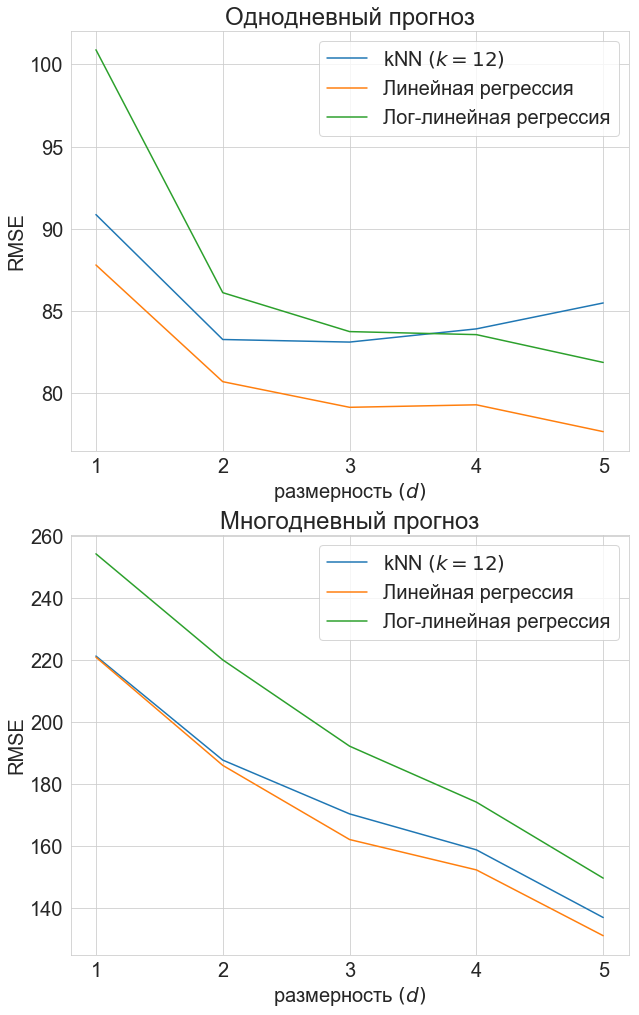

In [15]:
fig, axs = plt.subplots(figsize=(10, 17), nrows=2, ncols=1)

sns.lineplot(range(1, 6), one_day_results[:, 0], label='kNN $(k=12)$', ax=axs[0])
sns.lineplot(range(1, 6), seq_results[:, 0], label='kNN $(k=12)$', ax=axs[1])

sns.lineplot(range(1, 6), one_day_results[:, 1], label='Линейная регрессия', ax=axs[0])
sns.lineplot(range(1, 6), seq_results[:, 1], label='Линейная регрессия', ax=axs[1])

sns.lineplot(range(1, 6), one_day_results[:, 2], label='Лог-линейная регрессия', ax=axs[0])
sns.lineplot(range(1, 6), seq_results[:, 2], label='Лог-линейная регрессия', ax=axs[1])

for ax in axs:
    ax.legend(loc='upper right')
    ax.set_xlabel('размерность $(d)$')
    ax.set_ylabel('RMSE')
    ax.set_xticks(range(1, 6))

axs[0].set_title('Однодневный прогноз')
axs[1].set_title('Многодневный прогноз')
plt.savefig('images/models/models_rmse')
plt.show()

In [16]:
one_day_results = np.zeros((5, 26))
seq_results = np.zeros((5, 26))
for n in tqdm(range(1, 6)):
    vec_trans = VectorTransformer(length=n)
    X_train, y_train = vec_trans.transform(train_histories)
    X_test, y_test = vec_trans.transform(test_histories)
    for (i, k) in enumerate(range(1, 52, 2)):
        knn_regr = KNeighborsRegressor(n_neighbors=k)
        knn_regr.fit(X_train, y_train)
        one_day_results[n - 1, i] = rmsle(y_test, knn_regr.predict(X_test))
        seq_results[n - 1, i] = evaluate_model(knn_regr, test_histories, n, nan_rmsle, threshold=1.0)

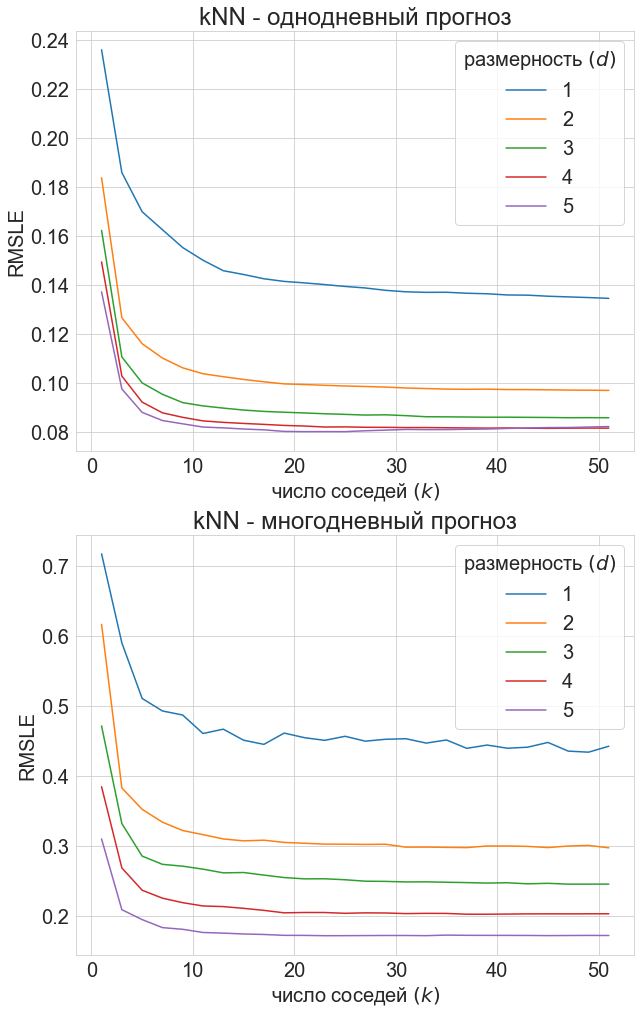

In [17]:
fig, axs = plt.subplots(figsize=(10, 17), nrows=2, ncols=1)

for i in range(5):
    sns.lineplot(range(1, 52, 2), one_day_results[i], label=str(i + 1), ax=axs[0])
    sns.lineplot(range(1, 52, 2), seq_results[i], label=str(i + 1), ax=axs[1])

for ax in axs:
    ax.legend(title=r'размерность $(d)$', loc='upper right')
    ax.set_xlabel(r'число соседей $(k)$')
    ax.set_ylabel('RMSLE')

axs[0].set_title('kNN - однодневный прогноз')
axs[1].set_title('kNN - многодневный прогноз')
plt.savefig('images/models/knn_rmsle')
plt.show()

In [18]:
one_day_results = np.zeros((5, 3))
seq_results = np.zeros((5, 3))
for n in range(1, 6):
    vec_trans = VectorTransformer(length=n)
    X_train, y_train = vec_trans.transform(train_histories)
    X_test, y_test = vec_trans.transform(test_histories)
    
    knn_regr = KNeighborsRegressor(n_neighbors=12)
    knn_regr.fit(X_train, y_train)
    one_day_results[n - 1, 0] = rmsle(y_test, knn_regr.predict(X_test))
    seq_results[n - 1, 0] = evaluate_model(knn_regr, test_histories, n, nan_rmsle, threshold=-np.inf)
    
    lin_regr = LinearRegression()
    lin_regr.fit(X_train, y_train)
    one_day_results[n - 1, 1] = rmsle(y_test, np.maximum(1.0, lin_regr.predict(X_test)))
    seq_results[n - 1, 1] = evaluate_model(lin_regr, test_histories, n, nan_rmsle, threshold=1.0)
    
    log_regr = LinearModel(x_transform=np.log1p, y_transform=np.log1p, y_inverse_transform=np.expm1)
    log_regr.fit(X_train, y_train)
    one_day_results[n - 1, 2] = rmsle(y_test, log_regr.predict(X_test))
    seq_results[n - 1, 2] = evaluate_model(log_regr, test_histories, n, nan_rmsle, threshold=-np.inf)

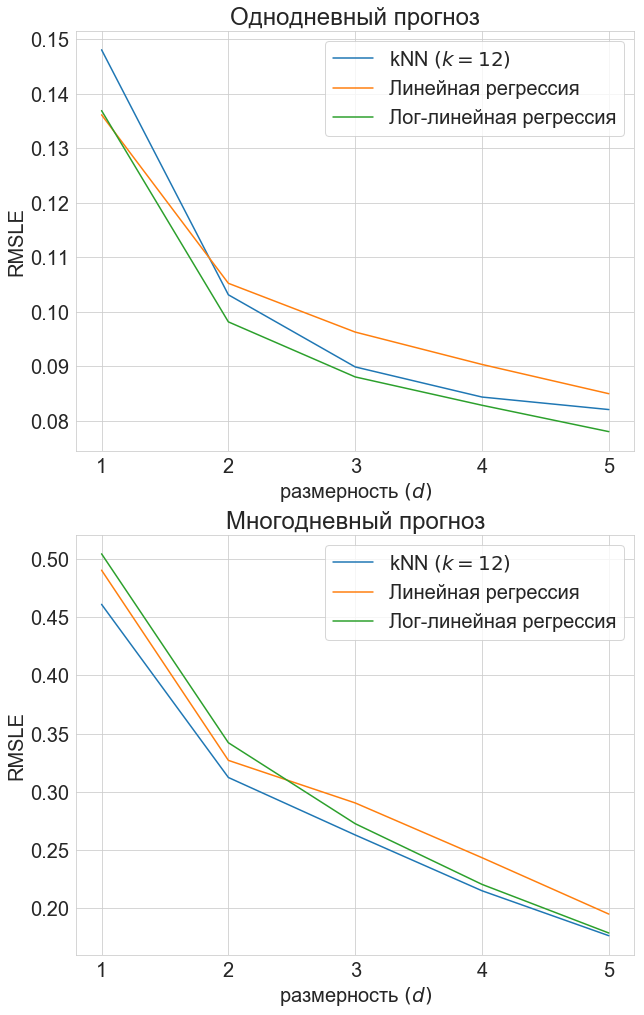

In [19]:
fig, axs = plt.subplots(figsize=(10, 17), nrows=2, ncols=1)

sns.lineplot(range(1, 6), one_day_results[:, 0], label='kNN $(k=12)$', ax=axs[0])
sns.lineplot(range(1, 6), seq_results[:, 0], label='kNN $(k=12)$', ax=axs[1])

sns.lineplot(range(1, 6), one_day_results[:, 1], label='Линейная регрессия', ax=axs[0])
sns.lineplot(range(1, 6), seq_results[:, 1], label='Линейная регрессия', ax=axs[1])

sns.lineplot(range(1, 6), one_day_results[:, 2], label='Лог-линейная регрессия', ax=axs[0])
sns.lineplot(range(1, 6), seq_results[:, 2], label='Лог-линейная регрессия', ax=axs[1])

for ax in axs:
    ax.legend(loc='upper right')
    ax.set_xlabel('размерность $(d)$')
    ax.set_ylabel('RMSLE')
    ax.set_xticks(range(1, 6))

axs[0].set_title('Однодневный прогноз')
axs[1].set_title('Многодневный прогноз')
plt.savefig('images/models/models_rmsle')
plt.show()

## Lifetime distribution

In [20]:
seq_gen = SequenceGenerator(verbose=True, filter_longitude=60)
histories_to_predict, left_mask, right_mask = seq_gen.transform(data, filter_center=False, filter_nan=True,
                                                                filter_right_edge=True, length=3)

In [71]:
multidim_regr = MultiDimensionalRegressor(regressor=KNeighborsRegressor, fit_decrease=True,
                                          dimensions=np.arange(1, 4), n_neighbors=1)
multidim_regr.fit(histories_filtered)

In [72]:
new_histories = np.zeros((histories_to_predict.shape[0], 40))
new_histories[~right_mask, :histories_to_predict.shape[1]] = histories_to_predict[~right_mask]
new_histories[right_mask] = predict_histories(multidim_regr, histories_to_predict[right_mask], 4,
                                              filter_area=45.0, max_lifetime=40)

In [23]:
def predict_histories(regressor, sequences, length, threshold=1.0, filter_area=45.0, max_lifetime=30):
    predicts = np.full((sequences.shape[0], max_lifetime), np.nan)
    predicts[:, :sequences.shape[1]] = sequences
    
    for i in range(length, predicts.shape[1]):
        preds = np.maximum(threshold, regressor.predict(np.nan_to_num(predicts[:, i - length:i])))
        predicts[:, i] = np.where(np.isnan(predicts[:, i]), preds, predicts[:, i])
        rand_decrease = np.random.choice([True, False], p=(0, 1), size=preds.size)
        predicts[:, i] = np.where(rand_decrease, predicts[:, i - 1] / 3, predicts[:, i])
    
    predicts[:, length:] = np.where(predicts[:, length:] > filter_area, predicts[:, length:], 0)
    return predicts

def get_lifetimes(predicts, length):
    return length + np.argmin(predicts[:, length:], axis=1) - (predicts[:, :length] == 0).sum(axis=1)

In [24]:
def lifetime_distr(histories_to_predict, train_histories, left_mask, right_mask, max_dim, n_neighbors):
    multidim_regr = MultiDimensionalRegressor(regressor=KNeighborsRegressor, fit_decrease=True,
                                          dimensions=np.arange(1, max_dim + 1), n_neighbors=n_neighbors)
    multidim_regr.fit(train_histories)
    new_histories = np.zeros((histories_to_predict.shape[0], 40))
    new_histories[~right_mask, :histories_to_predict.shape[1]] = histories_to_predict[~right_mask]
    new_histories[right_mask] = predict_histories(multidim_regr, histories_to_predict[right_mask], max_dim,
                                              filter_area=45.0, max_lifetime=40)
    lifetimes = get_lifetimes(new_histories[left_mask], max_dim)
    unique, counts = np.unique(lifetimes, return_counts=True)
    counts = counts / counts.sum()
    return counts

### Initial vs. algorithm

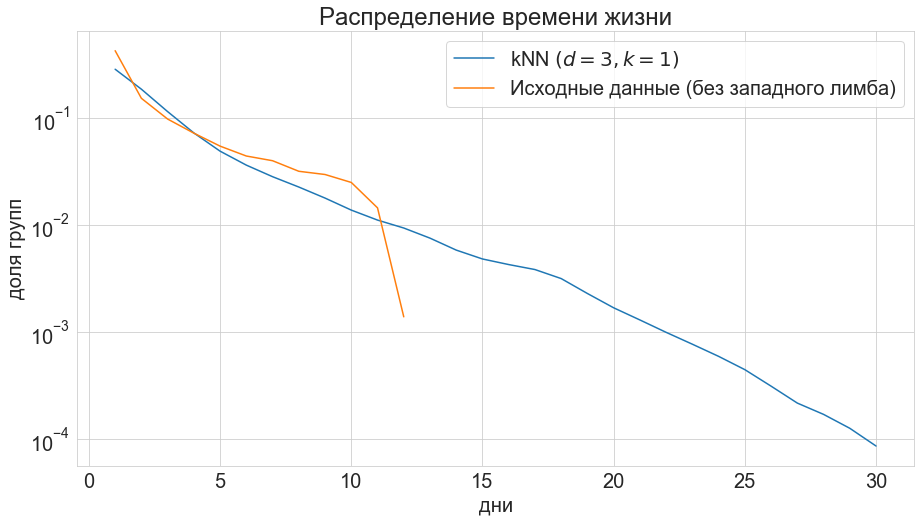

In [26]:
plt.figure(figsize=(15, 8))

lifetimes = lifetime_distr(histories_to_predict, train_histories, left_mask, right_mask,
                           max_dim=3, n_neighbors=1)
dates = np.arange(1, lifetimes.size + 1)
lifetimes = np.exp(gaussian_filter1d(np.log(lifetimes), 1))
sns.lineplot(dates, lifetimes, label='kNN $(d=3, k=1)$')

lifetimes = get_lifetimes(np.nan_to_num(histories_to_predict[left_mask]), 3)
unique, counts = np.unique(lifetimes, return_counts=True)
counts = counts / counts.sum()
dates = np.arange(1, counts.size + 1)
sns.lineplot(dates, counts, label='Исходные данные (без западного лимба)')

#plt.xscale('log')
plt.yscale('log')
plt.xlabel('дни')
plt.ylabel('доля групп')
plt.legend()
plt.title('Распределение времени жизни')
plt.savefig('images/lifetime (init & algo)')
plt.show()

### Tuning hyperparams

In [27]:
histories_to_predict = []
left_mask = []
right_mask = []

In [28]:
seq_gen = SequenceGenerator(verbose=True, filter_longitude=60)
arrays = seq_gen.transform(data, filter_center=False, filter_nan=True, filter_right_edge=True, length=2)
histories_to_predict.append(arrays[0])
left_mask.append(arrays[1])
right_mask.append(arrays[2])

In [29]:
seq_gen = SequenceGenerator(verbose=True, filter_longitude=60)
arrays = seq_gen.transform(data, filter_center=False, filter_nan=True, filter_right_edge=True, length=3)
histories_to_predict.append(arrays[0])
left_mask.append(arrays[1])
right_mask.append(arrays[2])

In [30]:
seq_gen = SequenceGenerator(verbose=True, filter_longitude=60)
arrays = seq_gen.transform(data, filter_center=False, filter_nan=True, filter_right_edge=True, length=4)
histories_to_predict.append(arrays[0])
left_mask.append(arrays[1])
right_mask.append(arrays[2])

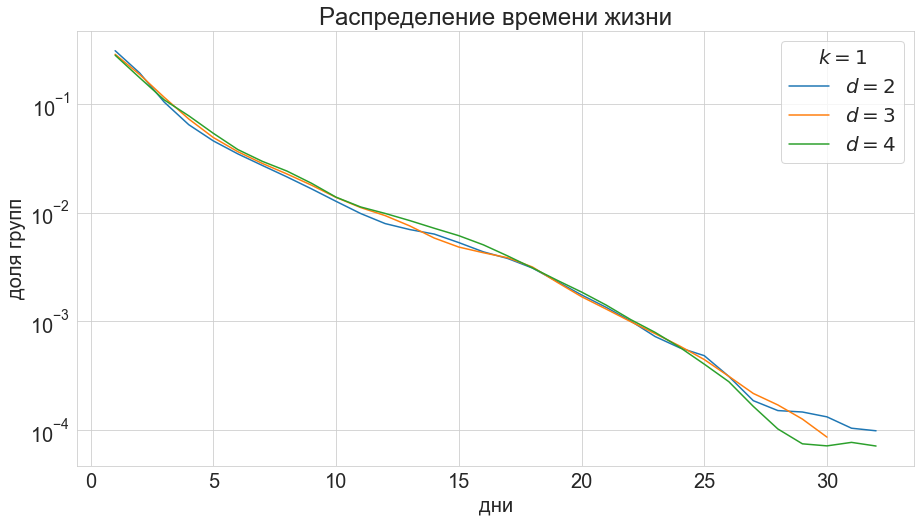

In [34]:
plt.figure(figsize=(15, 8))
for i, max_dim in enumerate([2, 3, 4]):
    lifetimes = lifetime_distr(histories_to_predict[i], train_histories, left_mask[i], right_mask[i],
                               max_dim=max_dim, n_neighbors=1)
    dates = np.arange(1, lifetimes.size + 1)
    lifetimes = np.exp(gaussian_filter1d(np.log(lifetimes), 1))
    sns.lineplot(dates, lifetimes, label='$d={}$'.format(max_dim))

plt.yscale('log')
plt.xlabel('дни')
plt.ylabel('доля групп')
plt.legend(title='$k=1$')
plt.title('Распределение времени жизни')
plt.savefig('images/params/lifetime (k=1)')
plt.show()

In [ ]:
plt.figure(figsize=(15, 8))
for j, k in enumerate([1, 10, 100]):
    lifetimes = lifetime_distr(histories_to_predict[0], train_histories, left_mask[0], right_mask[0],
                               max_dim=2, n_neighbors=k)
    dates = np.arange(1, lifetimes.size + 1)
    lifetimes = np.exp(gaussian_filter1d(np.log(lifetimes), 1))
    sns.lineplot(dates, lifetimes, label='$k={}$'.format(k))

plt.yscale('log')
plt.xlabel('дни')
plt.ylabel('доля групп')
plt.legend(title='$d=2$')
plt.title('Распределение времени жизни')
plt.savefig('images/params/lifetime (d=2)')
plt.show()

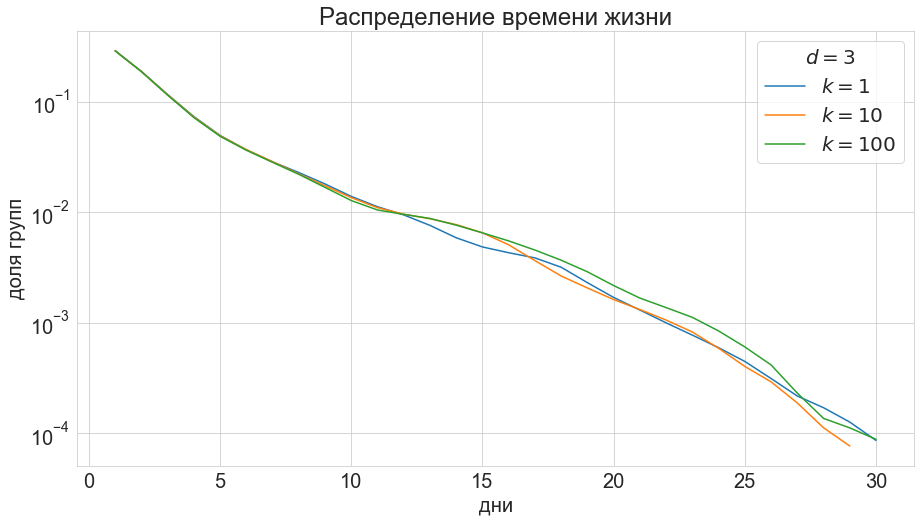

In [44]:
plt.figure(figsize=(15, 8))
for j, k in enumerate([1, 10, 100]):
    lifetimes = lifetime_distr(histories_to_predict[1], , left_mask[1], right_mask[1],
                               max_dim=3, n_neighbors=k)
    dates = np.arange(1, lifetimes.size + 1)
    lifetimes = np.exp(gaussian_filter1d(np.log(lifetimes), 1))
    sns.lineplot(dates, lifetimes, label='$k={}$'.format(k))

plt.yscale('log')
plt.xlabel('дни')
plt.ylabel('доля групп')
plt.legend(title='$d=3$')
plt.title('Распределение времени жизни')
plt.savefig('images/params/lifetime (d=3)')
plt.show()

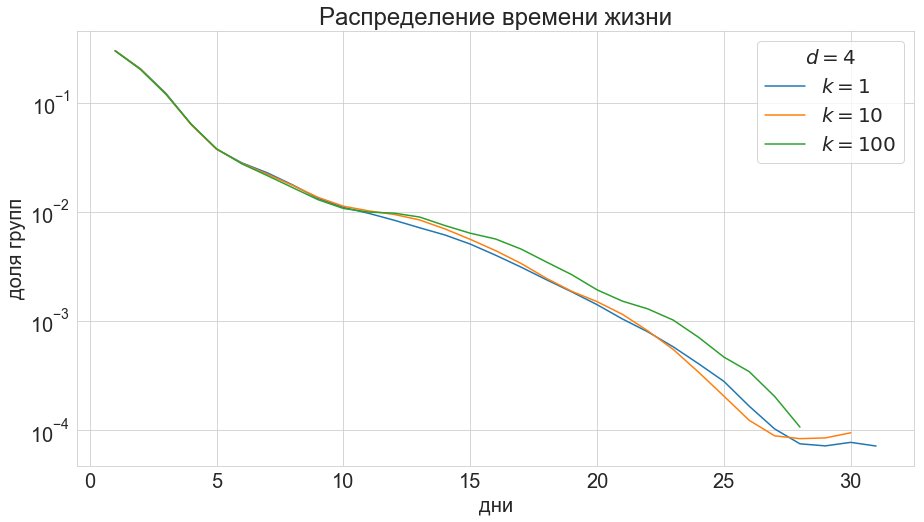

In [45]:
plt.figure(figsize=(15, 8))
for j, k in enumerate([1, 10, 100]):
    lifetimes = lifetime_distr(histories_to_predict[1], left_mask[1], right_mask[1],
                               max_dim=4, n_neighbors=k)
    dates = np.arange(1, lifetimes.size + 1)
    lifetimes = np.exp(gaussian_filter1d(np.log(lifetimes), 1))
    sns.lineplot(dates, lifetimes, label='$k={}$'.format(k))

plt.yscale('log')
plt.xlabel('дни')
plt.ylabel('доля групп')
plt.legend(title='$d=4$')
plt.title('Распределение времени жизни')
plt.savefig('images/params/lifetime (d=4)')
plt.show()

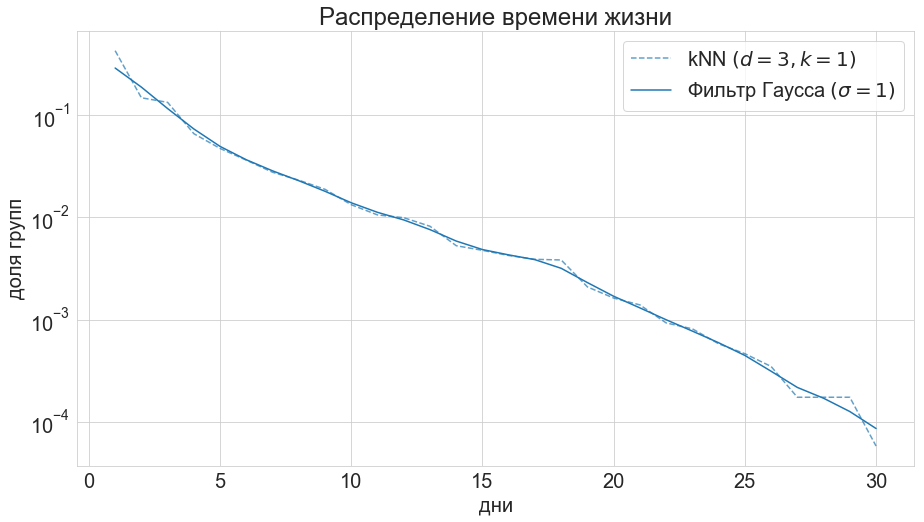

In [63]:
plt.figure(figsize=(15, 8))
lifetimes = lifetime_distr(histories_to_predict[1], left_mask[1], right_mask[1],
                           max_dim=3, n_neighbors=1)
dates = np.arange(1, lifetimes.size + 1)
sns.lineplot(dates, lifetimes, label='kNN $(d=3, k=1)$', alpha=0.7)
lifetimes = np.exp(gaussian_filter1d(np.log(lifetimes), 1))
ax = sns.lineplot(dates, lifetimes, label='Фильтр Гаусса $(\sigma=1)$')

ax.lines[0].set_linestyle('--')
ax.lines[1].set_color(ax.lines[0].get_color())

plt.yscale('log')
plt.xlabel('дни')
plt.ylabel('доля групп')
plt.legend()
plt.title('Распределение времени жизни')
plt.savefig('images/gauss_filter')
plt.show()

### Splitting data by time

In [67]:
median_time = data.obs_time.quantile(0.5)
old_ids = np.unique(data[data.obs_time <= median_time].id)
old_data = data[np.isin(data.id, old_ids)]
new_data = data[~np.isin(data.id, old_ids)]

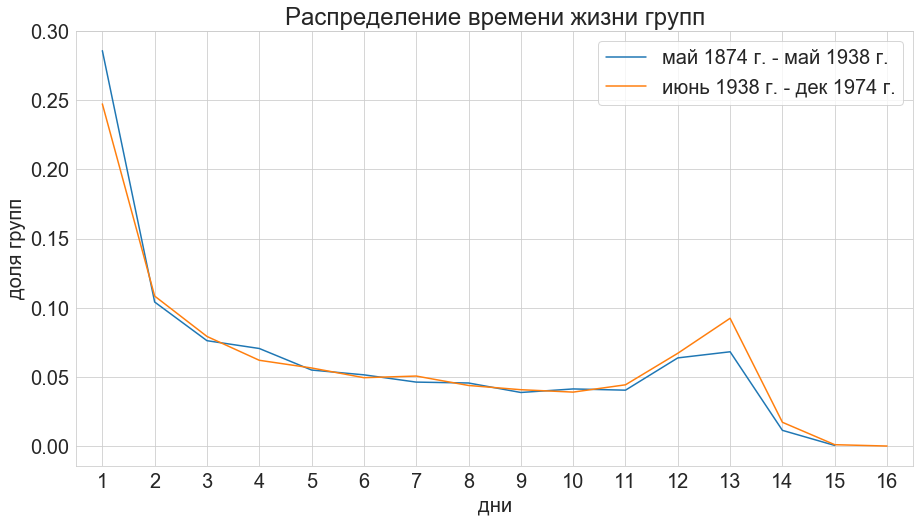

In [69]:
plt.figure(figsize=(15, 8))

grouped_data = old_data.groupby('id')
unique, counts = np.unique(grouped_data.size(), return_counts=True)
sns.lineplot(unique, counts / counts.sum(), label='май 1874 г. - май 1938 г.')

grouped_data = new_data.groupby('id')
unique, counts = np.unique(grouped_data.size(), return_counts=True)
sns.lineplot(unique, counts / counts.sum(), label='июнь 1938 г. - дек 1974 г.')

plt.xlabel('дни')
plt.ylabel('доля групп')
plt.xticks(np.arange(1, 17))
plt.xlim(0.5, 16.5)
plt.title('Распределение времени жизни групп')
plt.savefig('images/time_split/init_lifetime')
plt.show()

In [102]:
seq_gen = SequenceGenerator(verbose=True, filter_longitude=60)
old_histories, old_left_mask, old_right_mask = seq_gen.transform(old_data, filter_center=False, filter_nan=True,
                                                                 filter_right_edge=True, length=3)
new_histories, new_left_mask, new_right_mask = seq_gen.transform(new_data, filter_center=False, filter_nan=True,
                                                                 filter_right_edge=True, length=3)

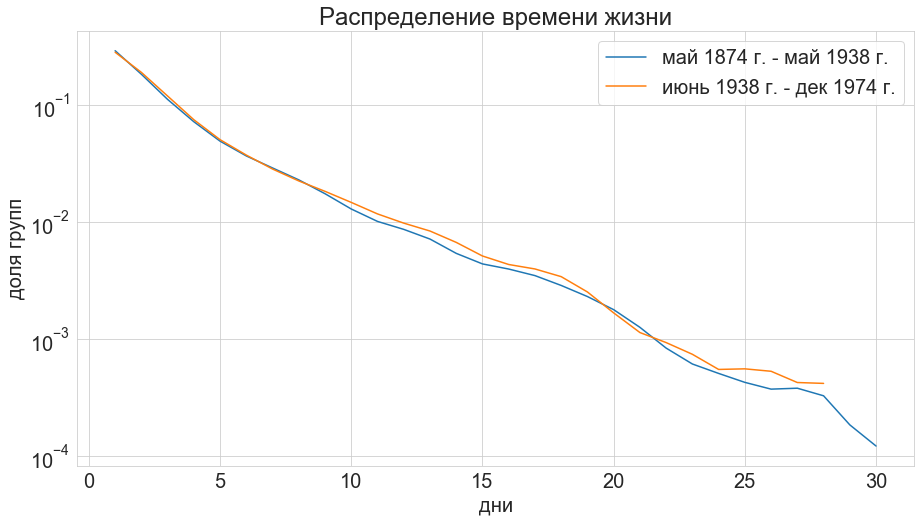

In [111]:
plt.figure(figsize=(15, 8))

lifetimes = lifetime_distr(old_histories, histories_filtered, old_left_mask, old_right_mask,
                           max_dim=3, n_neighbors=1)
dates = np.arange(1, lifetimes.size + 1)
lifetimes = np.exp(gaussian_filter1d(np.log(lifetimes), 1))
sns.lineplot(dates, lifetimes, label='май 1874 г. - май 1938 г.')

lifetimes = lifetime_distr(new_histories, histories_filtered, new_left_mask, new_right_mask,
                           max_dim=3, n_neighbors=1)
dates = np.arange(1, lifetimes.size + 1)
lifetimes = np.exp(gaussian_filter1d(np.log(lifetimes), 1))
sns.lineplot(dates, lifetimes, label='июнь 1938 г. - дек 1974 г.')

#plt.xscale('log')
plt.yscale('log')
plt.xlabel('дни')
plt.ylabel('доля групп')
plt.legend()
plt.title('Распределение времени жизни')
#plt.savefig('images/lifetime (init & algo, log x)')
plt.show()

## Decrease rate

In [205]:
new_histories = new_histories[left_mask]

In [206]:
decr_rates = np.array([])
area_ratios = np.array([])
gnev_wald = np.array([])
for i in tqdm(range(new_histories.shape[0])):
    seq = new_histories[i]
    mask = ~(np.isnan(seq) | (seq == 0))
    seq = seq[mask]
    seq = seq[np.argmax(seq):]
    if seq.size < 10 or not np.all(np.diff(seq) < 0):
        continue
    decr_rates = np.concatenate((decr_rates, (seq[:-2] - seq[2:]) / 2))
    area_ratios = np.concatenate((area_ratios, seq[1:-1] / np.max(seq)))
    gnev_wald = np.append(gnev_wald, np.max(seq) / mask.sum())

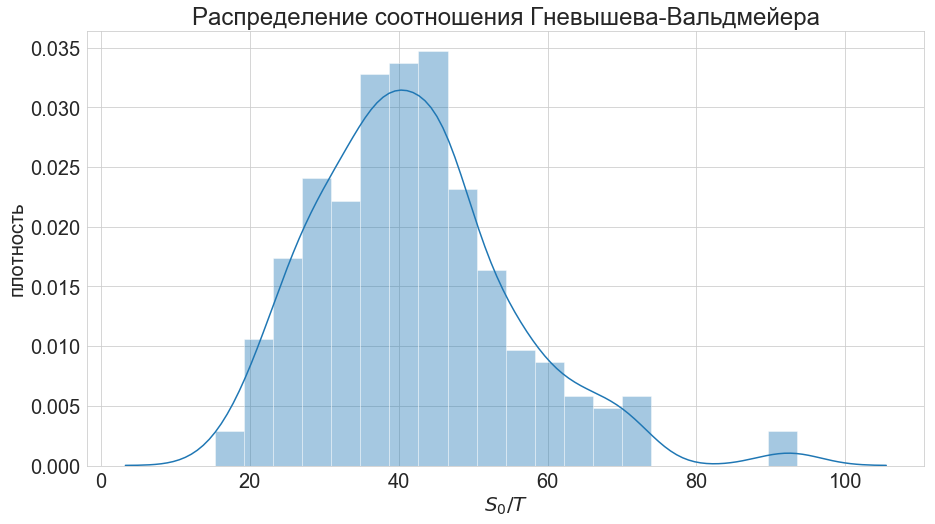

In [220]:
plt.figure(figsize=(15, 8))
sns.distplot(gnev_wald, bins=20)
plt.title('Распределение соотношения Гневышева-Вальдмейера')
plt.xlabel(r'$S_0 / T$')
plt.ylabel('плотность')
plt.savefig('images/gnev_wald')
plt.show()

In [191]:
class DecreaseRateOracle:
    def __init__(self, D, sigma):
        self.D = D
        self.sigma = sigma
    
    def func(self, x):
        alpha, gamma = x[0], x[1]
        hat_D = alpha * self.sigma ** gamma
        return 1 / 2 * np.mean((np.log(hat_D) - np.log(self.D)) ** 2)
    
    def grad(self, x):
        alpha, gamma = x[0], x[1]
        hat_D = alpha * self.sigma ** gamma
        base = (np.log(hat_D) - np.log(self.D))
        alpha_grad = np.mean(base / alpha)
        gamma_grad = np.mean(base * np.log(self.sigma))
        return np.array([alpha_grad, gamma_grad])

In [210]:
oracle = DecreaseRateOracle(D=decr_rates, sigma=area_ratios)

In [211]:
from scipy.optimize import minimize

In [212]:
minimize(oracle.func, x0=np.array([1, 0]), method='BFGS', jac=oracle.grad)

      fun: 0.12560348230710286
 hess_inv: array([[2.64018360e+04, 1.90895441e+02],
       [1.90895441e+02, 1.90789656e+00]])
      jac: array([ 4.74602517e-08, -5.49447290e-06])
  message: 'Optimization terminated successfully.'
     nfev: 21
      nit: 20
     njev: 21
   status: 0
  success: True
        x: array([85.97926806,  0.51375309])

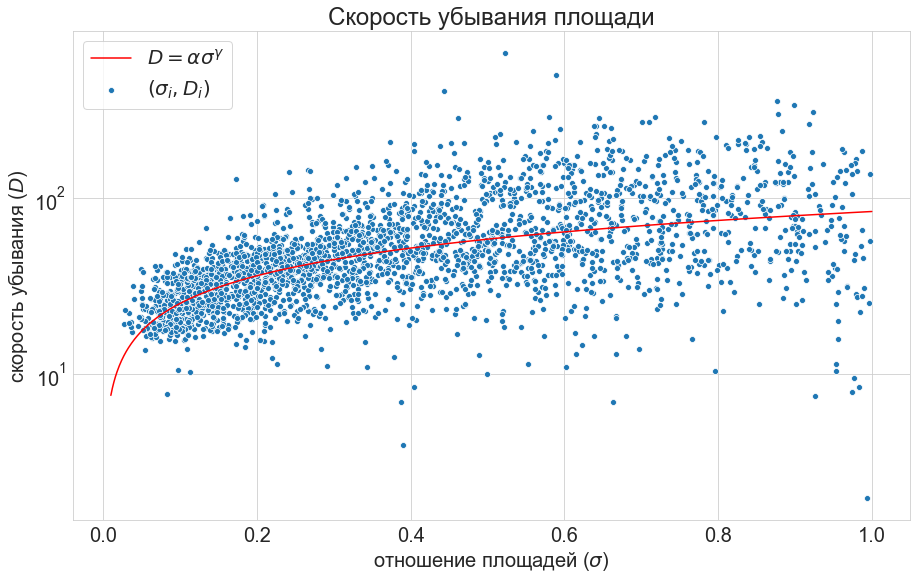

In [217]:
plt.figure(figsize=(15, 9))

sns.scatterplot(area_ratios, decr_rates, label=r'$(\sigma_i, D_i)$')
sns.lineplot(np.linspace(0.01, 1, 1000), 84.213 * np.linspace(0.01, 1, 1000) ** 0.522, color='red',
             label=r'$D = \alpha \sigma^{\gamma}$')

plt.xlabel('отношение площадей ($\sigma$)')
plt.ylabel('скорость убывания ($D$)')
plt.title('Скорость убывания площади')
plt.yscale('log')
plt.savefig('images/decr_rate')
plt.show()

In [195]:
sample = reduce_to_center(decr_rates, q_min=0.0, q_max=0.975)

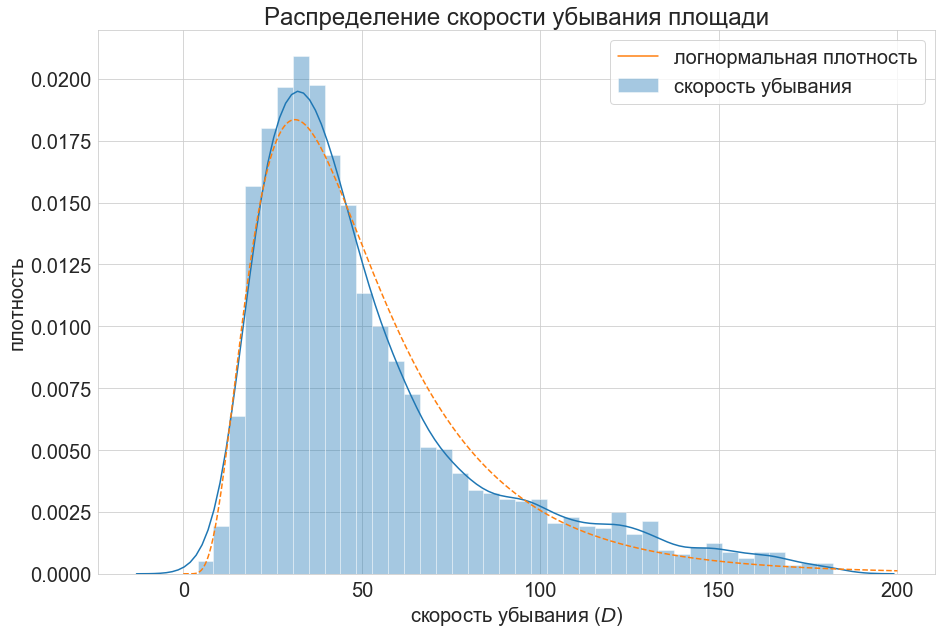

In [221]:
plt.figure(figsize=(15, 10))
s, theta = np.std(np.log(sample)), np.exp(np.mean(np.log(sample)))
sns.distplot(sample, bins=40, label='скорость убывания')
ax = sns.lineplot(np.linspace(0, 200, 1000), scipy.stats.lognorm.pdf(np.linspace(0, 200, 1000), s=s, scale=theta),
                  label='логнормальная плотность')
ax.lines[1].set_linestyle("--")

plt.xlabel('скорость убывания ($D$)')
plt.ylabel('плотность')
plt.title('Распределение скорости убывания площади')
plt.savefig('images/lognorm')
plt.show()